# Classificazione ECG
### Progetto reti di Linda Bianchini e Laura Cabras

Il progetto è strutturato su più punti che corrispondono anche all'ordine di compilazione dei file:
- Progetto_reti_punto0: Data processing
- punto1: Applicazione della rete descritta nel paper di riferimento (Ulas Baran Baloglu, Muhammed Talo, Ozal Yildirim, Ru San Tan, U Rajendra Acharya, Classification of myocardial infarction with multi-lead ECG signals and deep CNN, Pattern Recognition Letters, Volume 122, 2019, Pages 23-30,ISSN 0167-8655, https://doi.org/10.1016/j.patrec.2019.02.016.
(https://www.sciencedirect.com/science/article/pii/S016786551930056X))
- punto 2: Variazione del learning rate, del numero di layer interni della rete e dei parametri corrispondenti.
- punto 3: Applicazione della regressione L1 ed L2

In questa prima parte del progetto viene illustrato il data preprocessing realizzato sui dati 'PTB diagnostic ECG Database v1.0.0'. In questo dataset vi sono 290 pazienti, numerati da 1 a 294, mancano infatti i pazienti 124, 132, 134 e 161. Tra questi 148 presentano infarto miocardico, 52 sono sani e gli altri 90 presentano altri tipi di anomalie.

In [1]:
#si importano le libreria utili per la creazione della rete e per la realizzazione dei grafici
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential,utils, regularizers, initializers, optimizers
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout, Softmax
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
from tensorflow import keras
import tensorflow as tf

I dati sono salvati nel file data_raw.npz e le informazioni sui pazienti nel file meta.csv

In [2]:
data = np.load(r'C:\Users\bianc\Desktop\Reti neurali\data_raw.npz')

In [3]:
meta = pd.read_csv(r'C:\Users\bianc\Desktop\Reti neurali\meta.csv', header = None, error_bad_lines=False)
meta = pd.DataFrame(meta)

Creiamo innanzi tutto un vettore in cui inseriamo il numero di ciascun paziente, così che poi sia più semplice accedere alle informazioni di ognuno.

In [4]:
patients=[]
for i in range(294):
    if (i+1)!=124 and (i+1)!=132 and (i+1)!=134 and (i+1)!=161 and (i+1)!=139:
        patients.append(i+1)
patients=np.array(patients)

patient_new = []
for i in patients:
    if i < 10:
        p = 'patient00%i' % i
    elif i < 100 and i > 9:
        p = 'patient0%i' % i
    else:
        p = 'patient%i' % i
        
    for j in range(550):
        if p == meta.iloc[j][0]:
            if meta.iloc[j][13] == 'Myocardial infarction' or meta.iloc[j][13] == 'Healthy control':
                patient_new.append(i)
                break
                
patients = np.array(patient_new)                


La parte principale del data processing è consistita nell'isolare i singoli battiti. L'identificazione dell'infarto miocardico avviene in particolare considerando il picco R e l'onda ST, si sono dunque privilegiati questi segmenti. Il picco R è stato identificato grazie alla libreria neurokit2, ottimizzata per lo studio degli ECG. Di seguito si vede un esempio di identificazione degli R-peaks sul paziente 212.

In [5]:
import neurokit2 as nk #libreria per trovare gli R_peaks degli ECG
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5] 

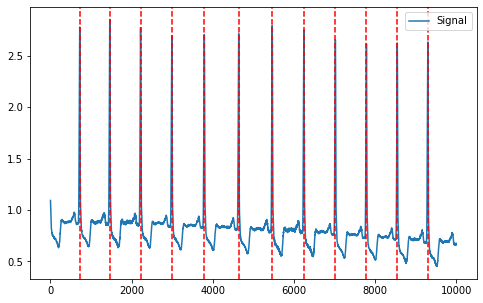

In [7]:
_, rpeaks = nk.ecg_peaks(data['patient212/s0434_re'][:, 0][0:10000], sampling_rate=1000)
plot = nk.events_plot(rpeaks['ECG_R_Peaks'], data['patient212/s0434_re'][:, 0][0:10000])

Una volta identificati i picchi R sono stati salvati i singoli battiti e salvati nel file 'ECG_lead2_paziente$i$.npz' dove $i$ è il numero del paziente. Si è scelto di considerare solo uno dei lead presenti nel dataset e di considerare un solo file per ogni paziente per osservare come fossero distribuiti i pazienti nelle varie classi.

In [94]:
for i in range(1,550):
    lead = []
    s='%s/%s' % (meta.iloc[i][0], meta.iloc[i][1])
    dat = data[s][:, 2]
    _, rpeaks = nk.ecg_peaks(dat, sampling_rate=1000)
    for k in rpeaks['ECG_R_Peaks']:
        lead.append(data[s][:, 2][k-250 : k+400] - data[s][:, 2][k-250]) 
        
    lead = np.array(lead, dtype=object)
    np.save('ECG_lead2_%s' %meta.iloc[i][0], lead)

Si salvano il numero di battiti per ogni paziente in num_battiti[] e i battiti stessi in X[].

In [8]:
num_battiti = []
X = []
for i in patients:
    if i < 10:
        file = 'ECG_lead2_patient00%i.npy' % i
    elif i < 100 and i > 9:
        file = 'ECG_lead2_patient0%i.npy' % i
    else:
        file = 'ECG_lead2_patient%i.npy' % i
    a = np.load(file, allow_pickle=True)
    c = 0
    for i in a:
        X.append(i)
        c+=1
    num_battiti.append(c)
    
num_battiti = np.array(num_battiti)
X = np.array(X)
print(num_battiti)

[153 151 135 155 124 149 101 114  19 166  35 125 169 154 128 109 121 133
 141 135 161 130 109 149 132 150 163  95 162 143 148 160 112 148 168 140
 132 114 154 139 165 134 157 121 163 145 126 128 139 126 128 150 155 132
 201 112 141 154 168 165 159 155 137 172 105 135 100 169 115 154 121 119
 120 136 149 167 202 158 128 161 153 110 120 116 138 168 176 177 140 119
 141 127 160 194 138 117 121 192 151 202 171 175 100 118 149  50  54 118
 132 145 165 127  41 197 141  57  55 152 164  44 156  57 129  44 149 133
 135  40  54 112 115 110 181 129 127 131 117 137  40 166 120 132  39 156
 118 118 136 139 211 196 141 119 121 117 147 122 108 134 123 122 157 161
 155 111 144 184 149 122 116 162 126 153 122 130 117 123 126 152 124 122
 145 110 134 138  87 110 153  98  92 124 122 103 142 180 121 140 219 143
 149]


C:\Users\bianc\Anaconda3\envs\CNN\lib\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Si suddividono i dati in train, test e validation rispettivamente 70 %, 15%, 15%

In [9]:
N = num_battiti.sum()
print(N)

n = np.arange(N)

import random
cut = int(0.85 * N) #85% del totale
random.shuffle(n)
X_train_index = n[:cut] # first 85% train
X_test_index = n[cut:] # last 15% test

cut1 = int(0.128 * len(X_train_index))
random.shuffle(X_train_index)
X_train_index = X_train_index[cut1:] # last 70% train
X_val_index = X_train_index[:cut1] # first 15% validation

X_test_index = np.array(X_test_index)
X_train_index = np.array(X_train_index)
X_val_index = np.array(X_val_index)

26560


In [10]:
print(X_train_index.size)
print(X_test_index.size)
print(X_val_index.size)
print(X_train_index.size + X_test_index.size + X_val_index.size)

19687
3984
2889
26560


Si crea il vettore dei label. I pazienti con infarto miocardico sono suddivisi in base alla parte del muscolo interessata.
- A anterior
- IL infero lateral
- AL antero lateral
- I inferior
- AS antero septal 
- IPL infero postero lateral
- PL postero lateral
- P posterior
- L lateral
- IP infero posterior
- ASL antero septo lateral

In [11]:
y_label = []
for i in patients:
    if i < 10:
        line = 'patient00%i' % i
    elif i < 100 and i > 9:
        line = 'patient0%i' % i
    else:
        line = 'patient%i' % i
    for i in range(1, 550):
        if meta.iloc[i][0] == line:
            if meta.iloc[i][13] == 'Myocardial infarction':
                if meta.iloc[i][14] == 'anterior':
                    label = 1
                elif meta.iloc[i][14] == 'infero-latera' or meta.iloc[i][14] == 'infero-lateral':
                    label = 2
                elif meta.iloc[i][14] == 'antero-lateral':
                    label = 3
                elif meta.iloc[i][14] == 'inferior':
                    label = 4
                elif meta.iloc[i][14] == 'antero-septal':
                    label = 5
                elif meta.iloc[i][14] == 'infero-posterior-lateral' or meta.iloc[i][14] == 'infero-postero-lateral' or meta.iloc[i][14] == 'infero-poster-lateral':
                    label = 6
                elif meta.iloc[i][14] == 'postero-lateral':
                    label = 7
                elif meta.iloc[i][14] == 'posterior':
                    label = 8
                elif meta.iloc[i][14] == 'lateral':
                    label = 9
                elif meta.iloc[i][14] == 'infero-posterior':
                    label = 10
                elif meta.iloc[i][14] == 'antero-septo-lateral':
                    label = 11
            elif meta.iloc[i][13] == 'Healthy control':
                label = 0
            y_label.append(label)
            break
            
y_label = np.array(y_label)
y_label.size

199

In [12]:
y_label_new = []
for i in range(y_label.size):
    for j in range(num_battiti[i]):
        y_label_new.append(y_label[i])
        
y_label = np.array(y_label_new)
y_label.size

26560

Si creano i vettori Xtrain, Ytrain, Xtest, Ytest, Xval e Yval

In [13]:
Xtrain = []
Ytrain = []
Xval = []
Yval = []
Xtest = []
Ytest = []
for i in X_train_index:
    Xtrain.append(X[i])
    Ytrain.append(y_label[i])
for i in X_test_index:
    Xtest.append(X[i])
    Ytest.append(y_label[i])
for i in X_val_index:
    Xval.append(X[i])
    Yval.append(y_label[i])
    
Xtrain = np.array(Xtrain, dtype=object)
Ytrain = np.array(Ytrain, dtype=object)
Xtest = np.array(Xtest, dtype=object)
Ytest = np.array(Ytest, dtype=object)
Xval = np.array(Xval, dtype=object)
Yval = np.array(Yval, dtype=object)

In [14]:
#tolgo tutti i battiti sottocampionati
Xtrain_new = []
Ytrain_new = []
Xval_new = []
Yval_new = []
Xtest_new = []
Ytest_new = []
for i in range(Xtrain.size):
    if Xtrain[i].size==650:
        Xtrain_new.append(Xtrain[i])
        Ytrain_new.append(Ytrain[i])
for i in range(Xtest.size):
    if Xtest[i].size==650:
        Xtest_new.append(Xtest[i])
        Ytest_new.append(Ytest[i])
for i in range(Xval.size):
    if Xval[i].size==650:
        Xval_new.append(Xval[i])
        Yval_new.append(Yval[i])
Xtrain = np.array(Xtrain_new, dtype=object)
Ytrain = np.array(Ytrain_new, dtype=object)
Xtest = np.array(Xtest_new, dtype=object)
Ytest = np.array(Ytest_new, dtype=object)
Xval = np.array(Xval_new, dtype=object)
Yval = np.array(Yval_new, dtype=object)

(array([6805., 1464., 2253., 1711., 3111., 2872.,  776.,  222.,  104.,
         128.,   78.,   98.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5]),
 <BarContainer object of 12 artists>)

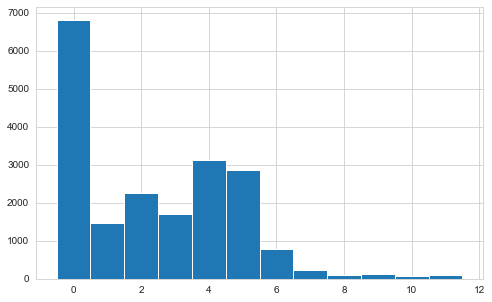

In [15]:
#distribuzione dei label sul set di training
sns.set_style('whitegrid')
n=[]
for i in range(13):
    n.append(i-0.5)
n=np.array(n)  
plt.hist(Ytrain,n)

In [14]:
print('shape train before: ',Xtrain.shape)
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain[0].size,1)
print('shape train after: ',Xtrain.shape)
print('shape validation before: ',Xval.shape)
Xval = Xval.reshape(Xval.shape[0],Xval[0].size,1)
print('shape validation before: ',Xval.shape)
input_shape = (Xtrain[0].size,1)

batch_size = 64
epochs = 50

shape train before:  (19620, 650)
shape train after:  (19620, 650, 1)
shape validation before:  (2882, 650)
shape validation before:  (2882, 650, 1)


In [16]:
Xtrain = np.asarray(Xtrain).astype('float32')
Xval = np.asarray(Xval).astype('float32')

In [17]:
#transform integer label into one-hot encodings
n_classes=12

Ytrain_cat = keras.utils.to_categorical(Ytrain, n_classes)
Yval_cat = keras.utils.to_categorical(Yval, n_classes)
Ytest_cat = keras.utils.to_categorical(Ytest, n_classes)

In [18]:
num_class = np.zeros(12)
for i in Ytrain:
    for j in range(12):
        if i==j:
            num_class[j]+=1

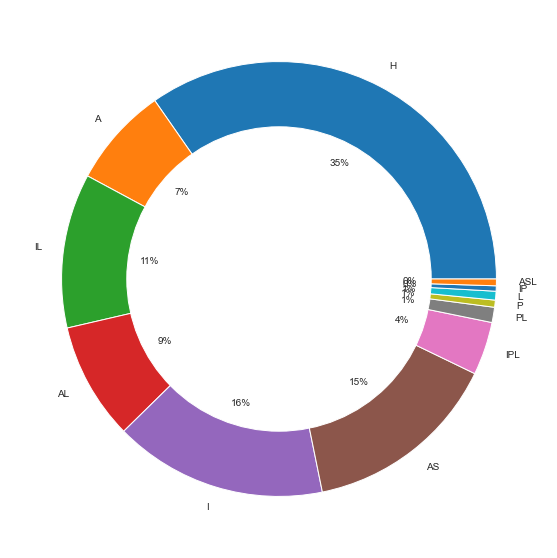

In [19]:
plt.figure(figsize= (10,10))
my_circle = plt.Circle((0,0), 0.7, color = 'white')

plt.pie(num_class, labels=['H', 'A', 'IL', 'AL', 'I', 'AS', 'IPL', 'PL', 'P', 'L', 'IP', 'ASL'], autopct = '%0.0f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

I dati sono evidentemente sbilanciati, con una buona maggioranza di persone sane. Si sono perciò considerati anche i battiti dei file multipli delle persone con infarto del miocardio secondo lo stesso procedimento realizzato precedentemente e salvandoli in 'ECG$i$.npz' cove $i$ è la riga corrispondente al file nel 'meta.csv'.


In [19]:
num_files = np.zeros(294) #vettore con il numero di files per ogni paziente
for i in range(1,550):
    for j in range(294):
        if j < 10:
            file = 'patient00%i' % (j+1)
        elif j < 100 and j > 9:
            file = 'patient0%i' % (j+1)
        else:
            file = 'patient%i' % (j+1)
        if file==meta.iloc[i][0]:
            num_files[j]+=1
num_files = num_files.astype('int')
print(num_files.size)
print(num_files)

294
[3 1 1 2 5 3 4 3 1 0 4 2 3 3 3 3 4 3 3 3 3 3 4 4 3 2 3 3 3 4 4 4 4 4 4 3 2
 3 3 4 4 4 3 4 4 4 3 4 4 4 4 1 1 4 1 1 1 1 1 1 1 1 1 1 4 3 3 1 4 1 1 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 1 3 4 4 4 4 4 5 4 4 4 4 4 4 0 3 1 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 2 1 1 1 1 1 1 0 1 1 2 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 2 1 1 0 1 1 2 2 1 1 2 2 1 1 1 1 3 1 1 1 1 1 7 2 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 2 2 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 2 1 1 1 5 1 1 3 1 1 1 1 2 1 1 1 2 1 1 1 1 1 3 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 4 1 1 1 1 3 1 1 2 1 1 1 1 2 2 1]


In [20]:
patients_MI_index = [] #vettore con l'indice dei pazienti con infarto del miocardio
for j in patients:
    if j < 10:
        file = 'patient00%i' % j
    elif j < 100 and j > 9:
        file = 'patient0%i' % j
    else:
        file = 'patient%i' % j
    for i in range(550):
        if meta.iloc[i][0] == file:
            if meta.iloc[i][13] == 'Myocardial infarction':
                patients_MI_index.append(j)
                break
patients_MI_index=np.array(patients_MI_index)
print(patients_MI_index)
print(patients_MI_index.size)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 108 111 120 128 135
 138 140 141 142 145 148 149 152 158 160 163 183 189 193 195 197 205 207
 211 223 226 230 231 259 261 265 268 270 273 274 280 282 283 287 290 291
 292 293 294]
147


In [21]:
MI_MoreThanOne = [] #vettore dei pazienti con infarto del miocardio
for i in range(len(patients_MI_index)):
    if num_files[patients_MI_index[i]-1]>1:
        MI_MoreThanOne.append(patients_MI_index[i])
        
MI_MoreThanOne = np.array(MI_MoreThanOne)
print(MI_MoreThanOne.size)

87


In [ ]:
#creazione dei files ECG.npz
for j in MI_MoreThanOne:
    if j < 10:
        file = 'patient00%i' % j
    elif j < 100 and j > 9:
        file = 'patient0%i' % j
    else:
        file = 'patient%i' % j
    c=0
    for i in range(1, 550):
        if meta.iloc[i][0] == file:
            while c<num_files[j-1]-1:
                lead = []
                s='%s/%s' % (meta.iloc[i][0], meta.iloc[i][1])
                dat = data[s][:, 2]
                _, rpeaks = nk.ecg_peaks(dat, sampling_rate=1000)
                for k in rpeaks['ECG_R_Peaks']:
                    lead.append(data[s][:, 2][k-250 : k+400] - data[s][:, 2][k-250]) 
        
                lead = np.array(lead, dtype=object)
                np.save('ECG%i' %i, lead)
                break

In [23]:
num_battiti_MI = np.zeros(294) # numero di battiti per ogni file dei pazienti con infarto del miocardio
X_MI = [] #ECG corrispondenti
for i in range(1, 550):
    p = int(meta.iloc[i][0].split('t')[2])
    file = 'ECG%i.npy' % i
    try:
        a = np.load(file, allow_pickle=True)
        c = 0
        for i in a:
            X_MI.append(i)
            c+=1
        num_battiti_MI[p-1] += c
    except:
        print('File does not exist')
    
num_battiti_MI = num_battiti_MI.astype(int)
X_MI = np.array(X_MI)
print(num_battiti_MI)
print(num_battiti_MI.size)

File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist
File does not exist


C:\Users\bianc\Anaconda3\envs\CNN\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [24]:
X_total = np.concatenate((X, X_MI))
X_total.shape

(70412,)

In [25]:
y_label_MI = np.zeros(294) #creazione dei vettori di label
for j in MI_MoreThanOne:
    if j < 10:
        line = 'patient00%i' % j
    elif j < 100 and i > 9:
        line = 'patient0%i' % j
    else:
        line = 'patient%i' % j
    for i in range(1, 550):
        if meta.iloc[i][0] == line:
            if meta.iloc[i][13] == 'Myocardial infarction':
                if meta.iloc[i][14] == 'anterior':
                    label = 1
                elif meta.iloc[i][14] == 'infero-latera' or meta.iloc[i][14] == 'infero-lateral':
                    label = 2
                elif meta.iloc[i][14] == 'antero-lateral':
                    label = 3
                elif meta.iloc[i][14] == 'inferior':
                    label = 4
                elif meta.iloc[i][14] == 'antero-septal':
                    label = 5
                elif meta.iloc[i][14] == 'infero-posterior-lateral' or meta.iloc[i][14] == 'infero-postero-lateral' or meta.iloc[i][14] == 'infero-poster-lateral':
                    label = 6
                elif meta.iloc[i][14] == 'postero-lateral':
                    label = 7
                elif meta.iloc[i][14] == 'posterior':
                    label = 8
                elif meta.iloc[i][14] == 'lateral':
                    label = 9
                elif meta.iloc[i][14] == 'infero-posterior':
                    label = 10
                elif meta.iloc[i][14] == 'antero-septo-lateral':
                    label = 11
            elif meta.iloc[i][13] == 'Healthy control':
                label = 0
            y_label_MI[j-1] += label
            break
            
y_label_MI = y_label_MI.astype(int)
y_label_MI.size

294

In [26]:
#togliamo gli zeri
y_label_new = []
num_battiti_new = []
for i in range(y_label_MI.size):
    if y_label_MI[i] != 0:
        y_label_new.append(y_label_MI[i])
        num_battiti_new.append(num_battiti_MI[i])
        
y_label_MI = np.array(y_label_new)
num_battiti_MI = np.array(num_battiti_new)
print(y_label_MI.size)
print(num_battiti_MI.size)

87
87


In [27]:
#creiamo il vettore di label per gli MI
y_label_new = []
for i in range(y_label_MI.size):
    for j in range(num_battiti_MI[i]):
        y_label_new.append(y_label_MI[i])
        
y_label_MI = np.array(y_label_new)
y_label_MI.size

43852

In [28]:
Y_total = np.concatenate((y_label, y_label_MI))

In [29]:
#togliamo i battiti sottocampionati
X_total_new = []
Y_total_new = []
for i in range(X_total.shape[0]):
    if X_total[i].size==650:
        X_total_new.append(X_total[i])
        Y_total_new.append(Y_total[i])
X_total = np.array(X_total_new)
Y_total = np.array(Y_total_new)
print(X_total.shape)
print(Y_total.size)

(70177, 650)
70177


In [30]:
N = X_total.shape[0]

n = np.arange(N)

import random
cut = int(0.85 * N) #85% del totale
random.shuffle(n)
X_train_index = n[:cut] # first 85% train
X_test_index = n[cut:] # last 15% test

cut1 = int(0.128 * len(X_train_index))
random.shuffle(X_train_index)
X_train_index = X_train_index[cut1:] # last 70% train
X_val_index = X_train_index[:cut1] # first 15% validation

X_test_index = np.array(X_test_index)
X_train_index = np.array(X_train_index)
X_val_index = np.array(X_val_index)

In [31]:
print(X_train_index.size)
print(X_test_index.size)
print(X_val_index.size)
print(X_train_index.size + X_test_index.size + X_val_index.size)

52015
10527
7635
70177


In [32]:
Xtrain = []
Ytrain = []
Xval = []
Yval = []
Xtest = []
Ytest = []
for i in X_train_index:
    Xtrain.append(X_total[i])
    Ytrain.append(Y_total[i])
for i in X_test_index:
    Xtest.append(X_total[i])
    Ytest.append(Y_total[i])
for i in X_val_index:
    Xval.append(X_total[i])
    Yval.append(Y_total[i])
    
Xtrain = np.array(Xtrain, dtype=object)
Ytrain = np.array(Ytrain, dtype=object)
Xtest = np.array(Xtest, dtype=object)
Ytest = np.array(Ytest, dtype=object)
Xval = np.array(Xval, dtype=object)
Yval = np.array(Yval, dtype=object)

(array([ 6708.,  5419.,  7108.,  6093., 11315., 10927.,  2597.,   675.,
          433.,   372.,    72.,   296.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5]),
 <BarContainer object of 12 artists>)

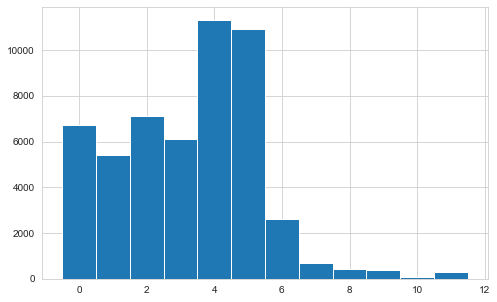

In [33]:
sns.set_style('whitegrid')
n=[]
for i in range(13):
    n.append(i-0.5)
n=np.array(n)  
plt.hist(Ytrain,n)

In [34]:
num_class = np.zeros(12)
for i in Ytrain:
    for j in range(12):
        if i==j:
            num_class[j]+=1

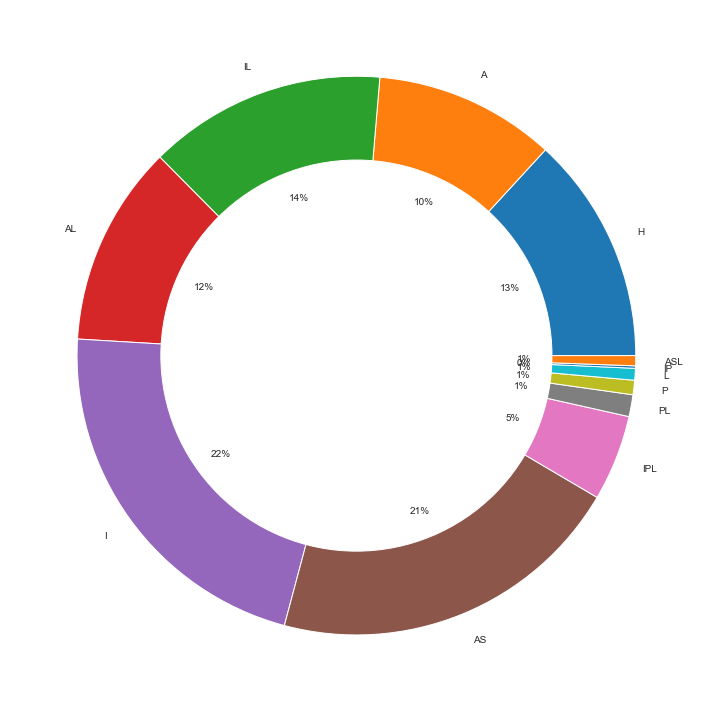

In [93]:
plt.figure(figsize= (10,10))
my_circle = plt.Circle((0,0), 0.7, color = 'white')

plt.pie(num_class, labels=['H', 'A', 'IL', 'AL', 'I', 'AS', 'IPL', 'PL', 'P', 'L', 'IP', 'ASL'], autopct = '%0.0f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.tight_layout()
plt.show()